# Starbucks Capstone Challenge

* The program used to create the data simulates how people make purchasing decisions and how those decisions are influenced by promotional offers.

* Each person in the simulation has some hidden traits that influence their purchasing patterns and are associated with their observable traits. People produce various events, including receiving offers, opening offers, and making purchases.

* As a simplification, there are no explicit products to track. Only the amounts of each transaction or offer are recorded.

* There are three types of offers that can be sent: buy-one-get-one (BOGO), discount, and informational. In a BOGO offer, a user needs to spend a certain amount to get a reward equal to that threshold amount. In a discount, a user gains a reward equal to a fraction of the amount spent. In an informational offer, there is no reward, but neither is there a requisite amount that the user is expected to spend. Offers can be delivered via multiple channels.

* <b>The basic task is to use the data to identify which groups of people are most responsive to each type of offer, and how best to present each type of offer.</b>


### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

<b>Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type.</b> This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. <b>For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).</b>

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

In [1]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns
%matplotlib inline

# read in the json files
portfolio = pd.read_json('portfolio.json', orient='records', lines=True)
profile = pd.read_json('profile.json', orient='records', lines=True)
transcript = pd.read_json('transcript.json', orient='records', lines=True)

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics

In [3]:
# settings to display all columns in a dataframe
pd.set_option("display.max_columns", None)

In [4]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reward      10 non-null     int64 
 1   channels    10 non-null     object
 2   difficulty  10 non-null     int64 
 3   duration    10 non-null     int64 
 4   offer_type  10 non-null     object
 5   id          10 non-null     object
dtypes: int64(3), object(3)
memory usage: 608.0+ bytes


In [3]:
portfolio_new = portfolio.sort_values(by = ['offer_type', 'difficulty', 'duration'], ascending = [True, False, False])
portfolio_new

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837


As we can see, there are three offer types - BOGO, discount and informational. <br><br>
For example, BOGO offer in the first row has difficulty of 10, meaning \\$10 is a minimum required amount that needs to be spent during 7 days (duration column). If that happens, a user gets a reward of \\$10 (reward column). User is informed about that offer through email, mobile and social channels (channels column). There is also offer id available (id_column). <br>
So, regarding BOGO, there are four offers in total; two where users need to spend \\$10 during 7 or 5 days, and if they do they get \\$10, and two where users need to spend \\$5 during 7 or 5 days and if they do, they get \\$5. <br><br>
There are four discount offers as well. In the first one, users need to spend \\$20 during 10 days, which would give them \\$5 discount if they do. In the next two offers, users need to spend \\$10 during 10 or 7 days, and if they do, they get \\$2 discount. Last discount offer requires that users spend \\$7 during 7 days, which qualifies them for \\$3 discount.<br><br>
Finally, informational offers don't have minimum purchase amount, and also don't give out any reward. As the name says, those offers are just providing information to the users; first one lasts 4 days and second one 3 days.

While we're at it, let's expand 'channels', so that each of the values gets its own column, and create dummies for 'offer_type'.

In [4]:
# function obtained from: 
# https://towardsdatascience.com/dealing-with-list-values-in-pandas-dataframes-a177e534f173

def boolean_df(item_lists, unique_items):
# Create empty dict
    bool_dict = {}
    
    # Loop through all the tags
    for i, item in enumerate(unique_items):
        
        # Apply boolean mask
        bool_dict[item] = item_lists.apply(lambda x: item in x)
            
    # Return the results as a dataframe
    return pd.DataFrame(bool_dict)

In [5]:
expanded_channels = boolean_df(portfolio_new['channels'], ['web', 'email', 'mobile', 'social'])
expanded_channels = expanded_channels.astype(int)
expanded_channels 

,web,email,mobile,social
0,0,1,1,1
1,1,1,1,1
3,1,1,1,0
8,1,1,1,1
4,1,1,0,0
6,1,1,1,1
9,1,1,1,0
5,1,1,1,1
2,1,1,1,0
7,0,1,1,1


In [6]:
portfolio_new = pd.merge(portfolio_new, expanded_channels, left_index = True, right_index = True).drop(['channels'], axis = 'columns')
portfolio_new

,reward,difficulty,duration,offer_type,id,web,email,mobile,social
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,0,1,1,1
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1
3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,1,0
8,5,5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1
4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,1,0,0
6,2,10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1
9,2,10,7,discount,2906b810c7d4411798c6938adc9daaa5,1,1,1,0
5,3,7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1
2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,1,0
7,0,0,3,informational,5a8bc65990b245e5a138643cd4eb9837,0,1,1,1


In [7]:
portfolio_new = pd.get_dummies(portfolio_new, columns = ['offer_type'])
portfolio_new = portfolio_new.rename(columns = {'difficulty': 'min_req_spend', 'duration': 'offer_duration_days', 'reward': 'offer_reward', 'offer_type_informational': 'offer_type_info'})
portfolio_new

,offer_reward,min_req_spend,offer_duration_days,id,web,email,mobile,social,offer_type_bogo,offer_type_discount,offer_type_info
0,10,10,7,ae264e3637204a6fb9bb56bc8210ddfd,0,1,1,1,1,0,0
1,10,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1,1,0,0
3,5,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,1,0,1,0,0
8,5,5,5,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1,1,0,0
4,5,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,1,0,0,0,1,0
6,2,10,10,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1,0,1,0
9,2,10,7,2906b810c7d4411798c6938adc9daaa5,1,1,1,0,0,1,0
5,3,7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1,0,1,0
2,0,0,4,3f207df678b143eea3cee63160fa8bed,1,1,1,0,0,0,1
7,0,0,3,5a8bc65990b245e5a138643cd4eb9837,0,1,1,1,0,0,1


In [8]:
# moving 'id' column to first place
col_name = 'id'
first_col = portfolio_new.pop(col_name)
portfolio_new.insert(0, 'offer_id', first_col)
portfolio_new

,offer_id,offer_reward,min_req_spend,offer_duration_days,web,email,mobile,social,offer_type_bogo,offer_type_discount,offer_type_info
0,ae264e3637204a6fb9bb56bc8210ddfd,10,10,7,0,1,1,1,1,0,0
1,4d5c57ea9a6940dd891ad53e9dbe8da0,10,10,5,1,1,1,1,1,0,0
3,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,5,7,1,1,1,0,1,0,0
8,f19421c1d4aa40978ebb69ca19b0e20d,5,5,5,1,1,1,1,1,0,0
4,0b1e1539f2cc45b7b9fa7c272da2e1d7,5,20,10,1,1,0,0,0,1,0
6,fafdcd668e3743c1bb461111dcafc2a4,2,10,10,1,1,1,1,0,1,0
9,2906b810c7d4411798c6938adc9daaa5,2,10,7,1,1,1,0,0,1,0
5,2298d6c36e964ae4a3e7e9706d1fb8c2,3,7,7,1,1,1,1,0,1,0
2,3f207df678b143eea3cee63160fa8bed,0,0,4,1,1,1,0,0,0,1
7,5a8bc65990b245e5a138643cd4eb9837,0,0,3,0,1,1,1,0,0,1


Now, profile table.

In [9]:
profile_new = profile
profile_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


In [10]:
profile_new.head(10)

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN
5,M,68,e2127556f4f64592b11af22de27a7932,20180426,70000.0
6,None,118,8ec6ce2a7e7949b1bf142def7d0e0586,20170925,NaN
7,None,118,68617ca6246f4fbc85e91a2a49552598,20171002,NaN
8,M,65,389bc3fa690240e798340f5a15918d5c,20180209,53000.0
9,None,118,8974fc5686fe429db53ddde067b88302,20161122,NaN


There are some missing values in gender and income columns, and it looks like those values might be missing for the same users.

In [11]:
profile_new[profile_new.applymap(lambda x: x is None)['gender']]

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN
6,None,118,8ec6ce2a7e7949b1bf142def7d0e0586,20170925,NaN
7,None,118,68617ca6246f4fbc85e91a2a49552598,20171002,NaN
...,...,...,...,...,...
16980,None,118,5c686d09ca4d475a8f750f2ba07e0440,20160901,NaN
16982,None,118,d9ca82f550ac4ee58b6299cf1e5c824a,20160415,NaN
16989,None,118,ca45ee1883624304bac1e4c8a114f045,20180305,NaN
16991,None,118,a9a20fa8b5504360beb4e7c8712f8306,20160116,NaN


In [12]:
profile_new[profile_new.applymap(lambda x: x is None)['gender']].income.unique()

array([nan])

In [13]:
profile_new[profile_new.applymap(lambda x: x is None)['gender']].age.unique()

array([118], dtype=int64)

In [14]:
len(profile_new[profile_new.applymap(lambda x: x is None)['gender']].income)

2175

In [15]:
len(profile_new[profile_new.applymap(lambda x: x is None)['gender']].age)

2175

Yes, for all columns where gender is None, income and age are missing as well.

In [16]:
round(profile_new['gender'].isnull().sum() / profile_new.shape[0], 2)

0.13

13% of userbase does not have age, gender and income data.

Column "became_member_on" is of type integer, however it should be date.

In [17]:
profile_new['became_member_on_date'] = pd.to_datetime(profile_new['became_member_on'].astype(str), format='%Y%m%d')
profile_new = profile_new.drop(['became_member_on'], axis = 'columns')

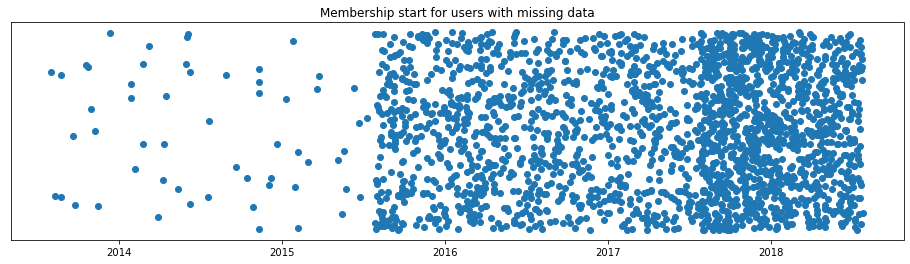

In [18]:
plt.figure(figsize=(16,4))
plt.scatter(profile_new[profile_new['age'] == 118]['became_member_on_date'], profile_new[profile_new['age'] == 118]['age'].index);
plt.title("Membership start for users with missing data");

#get current axes
ax = plt.gca()
#hide y-axis
ax.get_yaxis().set_visible(False)

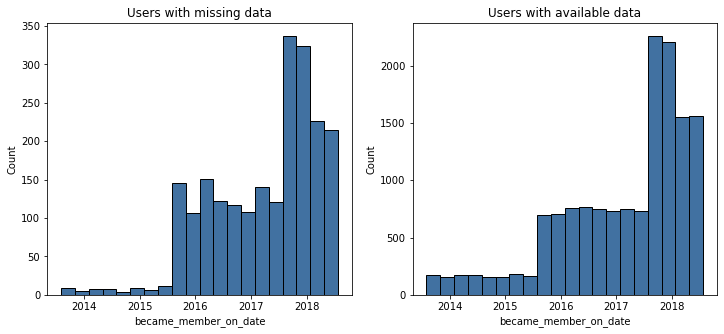

In [19]:
fig, axs = plt.subplots(1, 2, figsize = [12, 5]);

sns.histplot(data=profile_new[profile_new['age'] == 118], x='became_member_on_date', bins = 20, ax = axs[0], color = 'xkcd:darkish blue')
axs[0].set_title('Users with missing data');

sns.histplot(data=profile_new[profile_new['age'] != 118], x='became_member_on_date', bins = 20, ax = axs[1], color = 'xkcd:darkish blue')
axs[1].set_title('Users with available data');

As we can see, time-distribution is the same for all users, whether we have gender, age and income data for them or not.

In [20]:
# this function is originally from matplotlib website 
# https://matplotlib.org/stable/tutorials/introductory/lifecycle.html#sphx-glr-tutorials-introductory-lifecycle-py
# it is used to format income $ amounts for the third chart


def currency(x, pos):
    """The two arguments are the value and tick position"""
    if x >= 1e6:
        s = '${:1.1f}M'.format(x*1e-6)
    else:
        s = '${:1.0f}K'.format(x*1e-3)
    return s

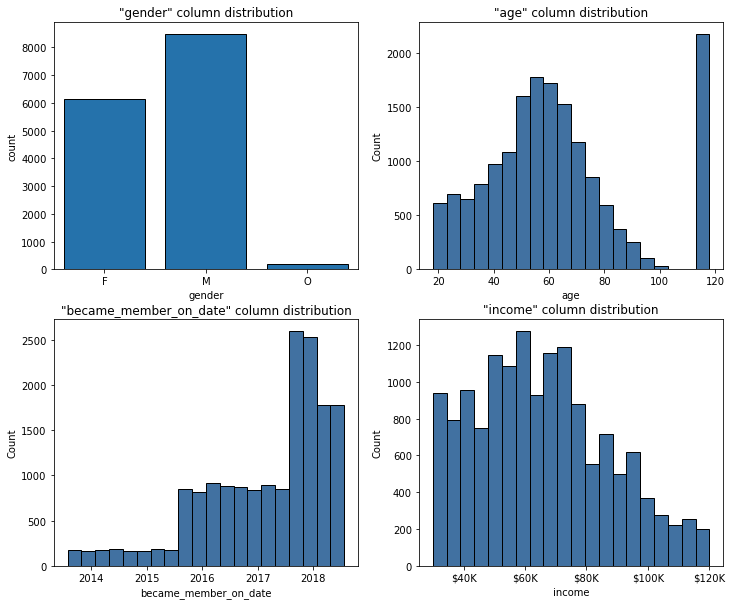

In [21]:
fig, axs = plt.subplots(2, 2, figsize = [12, 10]);

colors = ["#0F76C1"]
# Set your custom color palette
sns.set_palette(sns.color_palette(colors))

sns.countplot(x = 'gender', data = profile_new, color = '#0F76C1', edgecolor = "black", ax = axs[0, 0]);
axs[0, 0].set_title('"gender" column distribution')

sns.histplot(data=profile_new, x='age', bins = 20, ax = axs[0, 1], color = 'xkcd:darkish blue');
axs[0, 1].set_title('"age" column distribution');

sns.histplot(data=profile_new, x='became_member_on_date', bins = 20, ax = axs[1, 0], color = 'xkcd:darkish blue');
axs[1, 0].set_title('"became_member_on_date" column distribution');

sns.histplot(data=profile_new, x='income', bins = 20, ax = axs[1, 1], color = 'xkcd:darkish blue');
axs[1, 1].set_title('"income" column distribution');
axs[1, 1].xaxis.set_major_formatter(currency)

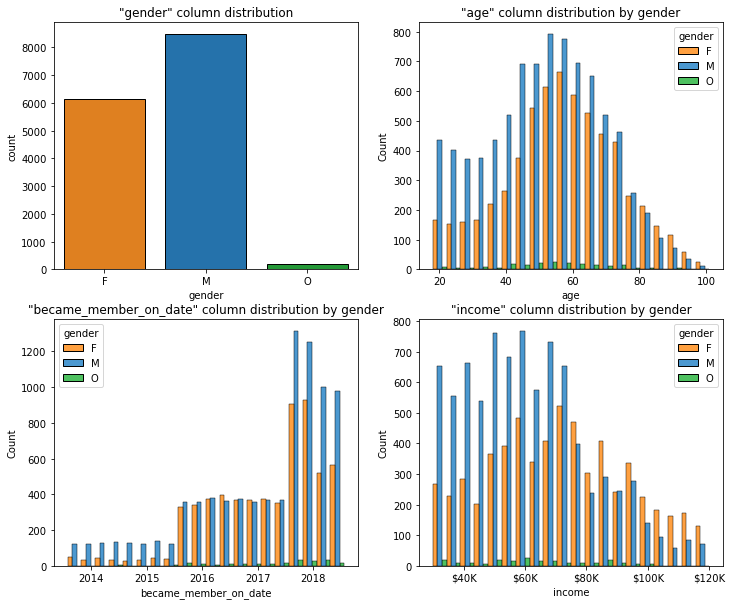

In [22]:
fig, axs = plt.subplots(2, 2, figsize = [12, 10]);

sns.countplot(x = 'gender', data = profile_new, edgecolor = "black", ax = axs[0, 0], palette = ['#FF8000', '#0F76C1', '#12AC2B']);
axs[0, 0].set_title('"gender" column distribution')

sns.histplot(data=profile_new, x='age', bins = 20, hue = 'gender', multiple = 'dodge', ax = axs[0, 1], palette = ['#FF8000', '#0F76C1', '#12AC2B']);
axs[0, 1].set_title('"age" column distribution by gender');

sns.histplot(data=profile_new, x='became_member_on_date', bins = 20, hue = 'gender', multiple = 'dodge', ax = axs[1, 0], palette = ['#FF8000', '#0F76C1', '#12AC2B']);
axs[1, 0].set_title('"became_member_on_date" column distribution by gender');

sns.histplot(data=profile_new, x='income', bins = 20, hue = 'gender', multiple = 'dodge', ax = axs[1, 1], palette = ['#FF8000', '#0F76C1', '#12AC2B']);
axs[1, 1].set_title('"income" column distribution by gender');
axs[1, 1].xaxis.set_major_formatter(currency)

Since there is no apparent cause for missing data in profile_new table (i.e. data is Missing Completely At Random), we will remove those users.

In [23]:
profile_new = profile_new[profile_new['age'] != 118]

Let's create dummy columns for gender, so that all columns are numerical, and let's move id column to the beginning.

In [24]:
profile_new = pd.get_dummies(profile_new, columns = ['gender'])
profile_new = profile_new.rename(columns = {'gender_F': 'F', 'gender_M': 'M', 'gender_O': 'O'})
profile_new

,age,id,income,became_member_on_date,F,M,O
1,55,0610b486422d4921ae7d2bf64640c50b,112000.0,2017-07-15,1,0,0
3,75,78afa995795e4d85b5d9ceeca43f5fef,100000.0,2017-05-09,1,0,0
5,68,e2127556f4f64592b11af22de27a7932,70000.0,2018-04-26,0,1,0
8,65,389bc3fa690240e798340f5a15918d5c,53000.0,2018-02-09,0,1,0
12,58,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,2017-11-11,0,1,0
...,...,...,...,...,...,...,...
16995,45,6d5f3a774f3d4714ab0c092238f3a1d7,54000.0,2018-06-04,1,0,0
16996,61,2cb4f97358b841b9a9773a7aa05a9d77,72000.0,2018-07-13,0,1,0
16997,49,01d26f638c274aa0b965d24cefe3183f,73000.0,2017-01-26,0,1,0
16998,83,9dc1421481194dcd9400aec7c9ae6366,50000.0,2016-03-07,1,0,0


In [25]:
# moving 'id' column to first place
col_name = 'id'
first_col = profile_new.pop(col_name)
profile_new.insert(0, 'user_id', first_col)
profile_new

,user_id,age,income,became_member_on_date,F,M,O
1,0610b486422d4921ae7d2bf64640c50b,55,112000.0,2017-07-15,1,0,0
3,78afa995795e4d85b5d9ceeca43f5fef,75,100000.0,2017-05-09,1,0,0
5,e2127556f4f64592b11af22de27a7932,68,70000.0,2018-04-26,0,1,0
8,389bc3fa690240e798340f5a15918d5c,65,53000.0,2018-02-09,0,1,0
12,2eeac8d8feae4a8cad5a6af0499a211d,58,51000.0,2017-11-11,0,1,0
...,...,...,...,...,...,...,...
16995,6d5f3a774f3d4714ab0c092238f3a1d7,45,54000.0,2018-06-04,1,0,0
16996,2cb4f97358b841b9a9773a7aa05a9d77,61,72000.0,2018-07-13,0,1,0
16997,01d26f638c274aa0b965d24cefe3183f,49,73000.0,2017-01-26,0,1,0
16998,9dc1421481194dcd9400aec7c9ae6366,83,50000.0,2016-03-07,1,0,0


In [26]:
print(min(profile_new['became_member_on_date']))
print(max(profile_new['became_member_on_date']))

2013-07-29 00:00:00
2018-07-26 00:00:00


In [27]:
profile_new['membership_days'] = dt.date(2018,7,29)
profile_new

,user_id,age,income,became_member_on_date,F,M,O,membership_days
1,0610b486422d4921ae7d2bf64640c50b,55,112000.0,2017-07-15,1,0,0,2018-07-29
3,78afa995795e4d85b5d9ceeca43f5fef,75,100000.0,2017-05-09,1,0,0,2018-07-29
5,e2127556f4f64592b11af22de27a7932,68,70000.0,2018-04-26,0,1,0,2018-07-29
8,389bc3fa690240e798340f5a15918d5c,65,53000.0,2018-02-09,0,1,0,2018-07-29
12,2eeac8d8feae4a8cad5a6af0499a211d,58,51000.0,2017-11-11,0,1,0,2018-07-29
...,...,...,...,...,...,...,...,...
16995,6d5f3a774f3d4714ab0c092238f3a1d7,45,54000.0,2018-06-04,1,0,0,2018-07-29
16996,2cb4f97358b841b9a9773a7aa05a9d77,61,72000.0,2018-07-13,0,1,0,2018-07-29
16997,01d26f638c274aa0b965d24cefe3183f,49,73000.0,2017-01-26,0,1,0,2018-07-29
16998,9dc1421481194dcd9400aec7c9ae6366,83,50000.0,2016-03-07,1,0,0,2018-07-29


In [28]:
print(type(min(profile_new['became_member_on_date'])))
print(type(min(profile_new['membership_days'])))

<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'datetime.date'>


In [29]:
profile_new.became_member_on_date = profile_new.became_member_on_date.apply(lambda x: x.date())

In [30]:
print(type(min(profile_new['became_member_on_date'])))
print(type(min(profile_new['membership_days'])))

<class 'datetime.date'>
<class 'datetime.date'>


In [31]:
profile_new['membership_days'] = (profile_new['membership_days'] - profile_new['became_member_on_date']).dt.days
profile_new = profile_new.drop(['became_member_on_date'], axis = 'columns')
profile_new

,user_id,age,income,F,M,O,membership_days
1,0610b486422d4921ae7d2bf64640c50b,55,112000.0,1,0,0,379
3,78afa995795e4d85b5d9ceeca43f5fef,75,100000.0,1,0,0,446
5,e2127556f4f64592b11af22de27a7932,68,70000.0,0,1,0,94
8,389bc3fa690240e798340f5a15918d5c,65,53000.0,0,1,0,170
12,2eeac8d8feae4a8cad5a6af0499a211d,58,51000.0,0,1,0,260
...,...,...,...,...,...,...,...
16995,6d5f3a774f3d4714ab0c092238f3a1d7,45,54000.0,1,0,0,55
16996,2cb4f97358b841b9a9773a7aa05a9d77,61,72000.0,0,1,0,16
16997,01d26f638c274aa0b965d24cefe3183f,49,73000.0,0,1,0,549
16998,9dc1421481194dcd9400aec7c9ae6366,83,50000.0,1,0,0,874


Let's take a look now at the transcript table.

In [32]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   person  306534 non-null  object
 1   event   306534 non-null  object
 2   value   306534 non-null  object
 3   time    306534 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [33]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [34]:
len(transcript.person.unique())

17000

In [35]:
transcript.event.unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'],
      dtype=object)

As we can see, types of events are "offer received", "offer viewed", "transaction", "offer completed".

In [36]:
transcript.time.unique()

array([  0,   6,  12,  18,  24,  30,  36,  42,  48,  54,  60,  66,  72,
        78,  84,  90,  96, 102, 108, 114, 120, 126, 132, 138, 144, 150,
       156, 162, 168, 174, 180, 186, 192, 198, 204, 210, 216, 222, 228,
       234, 240, 246, 252, 258, 264, 270, 276, 282, 288, 294, 300, 306,
       312, 318, 324, 330, 336, 342, 348, 354, 360, 366, 372, 378, 384,
       390, 396, 402, 408, 414, 420, 426, 432, 438, 444, 450, 456, 462,
       468, 474, 480, 486, 492, 498, 504, 510, 516, 522, 528, 534, 540,
       546, 552, 558, 564, 570, 576, 582, 588, 594, 600, 606, 612, 618,
       624, 630, 636, 642, 648, 654, 660, 666, 672, 678, 684, 690, 696,
       702, 708, 714], dtype=int64)

In [37]:
len(transcript.time.unique())

120

Time column represents number of hours since start of the test. The data begins at time = 0.

In [38]:
print('Experiment lasted for {} days'.format(transcript.time.max() / 24))

Experiment lasted for 29.75 days


In [39]:
transcript[transcript['event'] == 'offer completed'].head()

,person,event,value,time
12658,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,offer completed,{'offer_id': '2906b810c7d4411798c6938adc9daaa5...,0
12672,fe97aa22dd3e48c8b143116a8403dd52,offer completed,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...,0
12679,629fc02d56414d91bca360decdfa9288,offer completed,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...,0
12692,676506bad68e4161b9bbaffeb039626b,offer completed,{'offer_id': 'ae264e3637204a6fb9bb56bc8210ddfd...,0
12697,8f7dd3b2afe14c078eb4f6e6fe4ba97d,offer completed,{'offer_id': '4d5c57ea9a6940dd891ad53e9dbe8da0...,0


In [40]:
transcript.iloc[12658, 2]

{'offer_id': '2906b810c7d4411798c6938adc9daaa5', 'reward': 2}

In the case event is "offer completed", there are two key-value pairs in the dictionary. First one is offer_id, and second one is the reward that user received for completing the offer.

Now we need to break that dictionary into its elements, and put them in separate columns.

In [41]:
transcript_new = transcript.join(pd.DataFrame(transcript['value'].to_dict()).T)

In [42]:
transcript_new.head(2)

,person,event,value,time,offer id,amount,offer_id,reward
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,NaN
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,NaN


In [43]:
transcript_new[transcript_new['event'] == 'offer completed'].head(2)

,person,event,value,time,offer id,amount,offer_id,reward
12658,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,offer completed,{'offer_id': '2906b810c7d4411798c6938adc9daaa5...,0,NaN,NaN,2906b810c7d4411798c6938adc9daaa5,2
12672,fe97aa22dd3e48c8b143116a8403dd52,offer completed,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...,0,NaN,NaN,fafdcd668e3743c1bb461111dcafc2a4,2


It looks like if event is "offer completed", then offer id entry in the dictionary in 'value' column is written using underscore, and in all other cases it is written using just blank space.
We need to combine those two columns created from dictionary in 'value' column into one ('offer id' and 'offer_id'), since they contain the same information.

In [44]:
transcript_new['offer_id_2'] = np.where(transcript_new['offer_id'].isnull(), transcript_new['offer id'], transcript_new['offer_id'])

In [45]:
transcript_new.head()

,person,event,value,time,offer id,amount,offer_id,reward,offer_id_2
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,2906b810c7d4411798c6938adc9daaa5,NaN,NaN,NaN,2906b810c7d4411798c6938adc9daaa5
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,NaN,fafdcd668e3743c1bb461111dcafc2a4
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0


We don't need 'offer id' and 'offer_id' columns anymore, so we can remove them for clarity. We don't need value column either. Let's also rename some columns.

In [46]:
transcript_new = transcript_new.drop(['value', 'offer id', 'offer_id'], axis = 'columns')
transcript_new['time'] = transcript_new['time'] / 24
transcript_new = transcript_new.rename(columns = {'person': 'user_id' , 'time': 'days_since_start', 'offer_id_2': 'offer_id', 'amount': 'amount_spent', 'reward': 'reward_received'})
transcript_new

,user_id,event,days_since_start,amount_spent,reward_received,offer_id
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0.00,NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,a03223e636434f42ac4c3df47e8bac43,offer received,0.00,NaN,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,e2127556f4f64592b11af22de27a7932,offer received,0.00,NaN,NaN,2906b810c7d4411798c6938adc9daaa5
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0.00,NaN,NaN,fafdcd668e3743c1bb461111dcafc2a4
4,68617ca6246f4fbc85e91a2a49552598,offer received,0.00,NaN,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0
...,...,...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,29.75,1.59,NaN,NaN
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,29.75,9.53,NaN,NaN
306531,a00058cf10334a308c68e7631c529907,transaction,29.75,3.61,NaN,NaN
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,29.75,3.53,NaN,NaN


In [47]:
transcript_new.duplicated().sum()

397

There are 374 duplicated values, which we need to remove from the table. 

In [48]:
transcript_new = transcript_new.drop_duplicates(keep = 'first')
transcript_new.duplicated().sum()

0

#### We will try to predict whether offer was successful or not, and we will ignore transactions.

The offer was successful if:
* it was received, viewed and completed, in that order. <br>

The offer was not successful if: <br>
* it was only received, but not viewed or completed, 
* if it was received and viewed, but not completed, 
* if it was completed before it was viewed or 
* if it was received and completed but not viewed.

<b>Actually, we can't ignore transactions, because of informational offers.</b> We need to check if there was a transaction after the offer was received, and within the duration of the offer - in which case informational offer would be successful.

In [49]:
transcript_new = transcript_new.replace(['offer received', 'offer viewed', 'offer completed'], ['offer_received', 'offer_viewed', 'offer_completed'])
transcript_offer = transcript_new[transcript_new['event'] != 'transaction']
transcript_offer = transcript_offer.drop(['amount_spent'], axis = 'columns')
transcript_offer

,user_id,event,days_since_start,reward_received,offer_id
0,78afa995795e4d85b5d9ceeca43f5fef,offer_received,0.00,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,a03223e636434f42ac4c3df47e8bac43,offer_received,0.00,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,e2127556f4f64592b11af22de27a7932,offer_received,0.00,NaN,2906b810c7d4411798c6938adc9daaa5
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer_received,0.00,NaN,fafdcd668e3743c1bb461111dcafc2a4
4,68617ca6246f4fbc85e91a2a49552598,offer_received,0.00,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0
...,...,...,...,...,...
306497,a6f84f4e976f44508c358cc9aba6d2b3,offer_completed,29.75,3.0,2298d6c36e964ae4a3e7e9706d1fb8c2
306506,b895c57e8cd047a8872ce02aa54759d6,offer_completed,29.75,2.0,fafdcd668e3743c1bb461111dcafc2a4
306507,8dda575c2a1d44b9ac8e8b07b93d1f8e,offer_viewed,29.75,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7
306509,8431c16f8e1d440880db371a68f82dd0,offer_completed,29.75,2.0,fafdcd668e3743c1bb461111dcafc2a4


In [50]:
transcript_offer_pivot = transcript_offer.pivot(columns = ['event'], values = 'days_since_start')
transcript_offer_pivot

event,offer_completed,offer_received,offer_viewed
0,NaN,0.0,NaN
1,NaN,0.0,NaN
2,NaN,0.0,NaN
3,NaN,0.0,NaN
4,NaN,0.0,NaN
...,...,...,...
306497,29.75,NaN,NaN
306506,29.75,NaN,NaN
306507,NaN,NaN,29.75
306509,29.75,NaN,NaN


In [51]:
transcript_offer = transcript_offer.join(transcript_offer_pivot, how = 'inner')
transcript_offer = transcript_offer.drop(['event', 'days_since_start'], axis = 'columns')
transcript_offer

,user_id,reward_received,offer_id,offer_completed,offer_received,offer_viewed
0,78afa995795e4d85b5d9ceeca43f5fef,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,0.0,NaN
1,a03223e636434f42ac4c3df47e8bac43,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,0.0,NaN
2,e2127556f4f64592b11af22de27a7932,NaN,2906b810c7d4411798c6938adc9daaa5,NaN,0.0,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,NaN,fafdcd668e3743c1bb461111dcafc2a4,NaN,0.0,NaN
4,68617ca6246f4fbc85e91a2a49552598,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,0.0,NaN
...,...,...,...,...,...,...
306497,a6f84f4e976f44508c358cc9aba6d2b3,3.0,2298d6c36e964ae4a3e7e9706d1fb8c2,29.75,NaN,NaN
306506,b895c57e8cd047a8872ce02aa54759d6,2.0,fafdcd668e3743c1bb461111dcafc2a4,29.75,NaN,NaN
306507,8dda575c2a1d44b9ac8e8b07b93d1f8e,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,29.75
306509,8431c16f8e1d440880db371a68f82dd0,2.0,fafdcd668e3743c1bb461111dcafc2a4,29.75,NaN,NaN


In [52]:
transcript_offer = transcript_offer[['user_id', 'offer_id', 'offer_received', 'offer_viewed', 'offer_completed', 'reward_received']]
transcript_offer = transcript_offer.sort_values(by = ['user_id', 'offer_id'])
transcript_offer.head(30)

,user_id,offer_id,offer_received,offer_viewed,offer_completed,reward_received
247879,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,24.0,NaN,NaN,NaN
258884,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,NaN,NaN,24.00,2.0
113605,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,14.0,NaN,NaN,NaN
139992,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,NaN,15.50,NaN,NaN
55972,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,7.0,NaN,NaN,NaN
77705,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,NaN,8.00,NaN,NaN
153401,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,17.0,NaN,NaN,NaN
168413,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,NaN,NaN,17.25,5.0
187554,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,NaN,19.00,NaN,NaN
204340,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,21.0,NaN,NaN,NaN


It looks like we might be able to use forward fill for "offer_received" column.

In [53]:
transcript_offer['offer_received'] = transcript_offer.groupby(['user_id', 'offer_id'])['offer_received'].ffill()
transcript_offer.head(30)

,user_id,offer_id,offer_received,offer_viewed,offer_completed,reward_received
247879,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,24.0,NaN,NaN,NaN
258884,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,24.0,NaN,24.00,2.0
113605,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,14.0,NaN,NaN,NaN
139992,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,14.0,15.50,NaN,NaN
55972,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,7.0,NaN,NaN,NaN
77705,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,7.0,8.00,NaN,NaN
153401,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,17.0,NaN,NaN,NaN
168413,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,17.0,NaN,17.25,5.0
187554,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,17.0,19.00,NaN,NaN
204340,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,21.0,NaN,NaN,NaN


In [54]:
transcript_offer['offer_viewed'] = transcript_offer.groupby(['user_id', 'offer_id', 'offer_received'])['offer_viewed'].bfill()
transcript_offer.head(30)

,user_id,offer_id,offer_received,offer_viewed,offer_completed,reward_received
247879,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,24.0,NaN,NaN,NaN
258884,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,24.0,NaN,24.00,2.0
113605,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,14.0,15.50,NaN,NaN
139992,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,14.0,15.50,NaN,NaN
55972,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,7.0,8.00,NaN,NaN
77705,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,7.0,8.00,NaN,NaN
153401,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,17.0,19.00,NaN,NaN
168413,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,17.0,19.00,17.25,5.0
187554,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,17.0,19.00,NaN,NaN
204340,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,21.0,22.50,NaN,NaN


Great, looks like it worked!! Now we need to do forward fill as well.

In [55]:
transcript_offer['offer_viewed'] = transcript_offer.groupby(['user_id', 'offer_id', 'offer_received'])['offer_viewed'].ffill()
transcript_offer.head(30)

,user_id,offer_id,offer_received,offer_viewed,offer_completed,reward_received
247879,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,24.0,NaN,NaN,NaN
258884,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,24.0,NaN,24.00,2.0
113605,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,14.0,15.50,NaN,NaN
139992,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,14.0,15.50,NaN,NaN
55972,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,7.0,8.00,NaN,NaN
77705,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,7.0,8.00,NaN,NaN
153401,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,17.0,19.00,NaN,NaN
168413,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,17.0,19.00,17.25,5.0
187554,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,17.0,19.00,NaN,NaN
204340,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,21.0,22.50,NaN,NaN


We need to do the same thing for "offer_completed".

In [56]:
transcript_offer['offer_completed'] = transcript_offer.groupby(['user_id', 'offer_id', 'offer_received'])['offer_completed'].bfill()
transcript_offer.head(30)

,user_id,offer_id,offer_received,offer_viewed,offer_completed,reward_received
247879,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,24.0,NaN,24.00,NaN
258884,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,24.0,NaN,24.00,2.0
113605,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,14.0,15.50,NaN,NaN
139992,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,14.0,15.50,NaN,NaN
55972,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,7.0,8.00,NaN,NaN
77705,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,7.0,8.00,NaN,NaN
153401,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,17.0,19.00,17.25,NaN
168413,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,17.0,19.00,17.25,5.0
187554,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,17.0,19.00,NaN,NaN
204340,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,21.0,22.50,22.00,NaN


In [57]:
transcript_offer['offer_completed'] = transcript_offer.groupby(['user_id', 'offer_id', 'offer_received'])['offer_completed'].ffill()
transcript_offer.head(30)

,user_id,offer_id,offer_received,offer_viewed,offer_completed,reward_received
247879,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,24.0,NaN,24.00,NaN
258884,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,24.0,NaN,24.00,2.0
113605,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,14.0,15.50,NaN,NaN
139992,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,14.0,15.50,NaN,NaN
55972,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,7.0,8.00,NaN,NaN
77705,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,7.0,8.00,NaN,NaN
153401,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,17.0,19.00,17.25,NaN
168413,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,17.0,19.00,17.25,5.0
187554,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,17.0,19.00,17.25,NaN
204340,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,21.0,22.50,22.00,NaN


We need to do the same thing for 'reward_received' column as well.

In [58]:
transcript_offer['reward_received'] = transcript_offer.groupby(['user_id', 'offer_id', 'offer_received'])['reward_received'].bfill()
transcript_offer['reward_received'] = transcript_offer.groupby(['user_id', 'offer_id', 'offer_received'])['reward_received'].ffill()
transcript_offer.head(30)

,user_id,offer_id,offer_received,offer_viewed,offer_completed,reward_received
247879,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,24.0,NaN,24.00,2.0
258884,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,24.0,NaN,24.00,2.0
113605,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,14.0,15.50,NaN,NaN
139992,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,14.0,15.50,NaN,NaN
55972,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,7.0,8.00,NaN,NaN
77705,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,7.0,8.00,NaN,NaN
153401,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,17.0,19.00,17.25,5.0
168413,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,17.0,19.00,17.25,5.0
187554,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,17.0,19.00,17.25,5.0
204340,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,21.0,22.50,22.00,2.0


Now we need to remove duplicates and finally we will have what we need to determine if offer was successful or not.

In [59]:
transcript_offer = transcript_offer.drop_duplicates(keep = 'first')
transcript_offer['reward_received'] = transcript_offer['reward_received'].fillna(0)
transcript_offer

,user_id,offer_id,offer_received,offer_viewed,offer_completed,reward_received
247879,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,24.0,NaN,24.00,2.0
113605,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,14.0,15.50,NaN,0.0
55972,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,7.0,8.00,NaN,0.0
153401,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,17.0,19.00,17.25,5.0
204340,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,21.0,22.50,22.00,2.0
...,...,...,...,...,...,...
112214,ffff82501cea40309d5fdd7edcca4a07,2906b810c7d4411798c6938adc9daaa5,14.0,14.75,16.00,2.0
152030,ffff82501cea40309d5fdd7edcca4a07,2906b810c7d4411798c6938adc9daaa5,17.0,17.25,17.25,2.0
246495,ffff82501cea40309d5fdd7edcca4a07,2906b810c7d4411798c6938adc9daaa5,24.0,24.25,24.00,2.0
202962,ffff82501cea40309d5fdd7edcca4a07,9b98b8c7a33c4b65b9aebfe6a799e6d9,21.0,22.25,21.00,5.0


In [60]:
transcript_offer['offer_received'].unique()

array([24., 14.,  7., 17., 21.,  0.])

Just checking if there is a case where time for 'offer_received' is missing - there shouldn't be, and as we see there is no such instance!

In [61]:
transcript_offer['offer_successful'] = np.where(transcript_offer['offer_completed'] >= transcript_offer['offer_viewed'], 1, 0).copy()
transcript_offer

,user_id,offer_id,offer_received,offer_viewed,offer_completed,reward_received,offer_successful
247879,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,24.0,NaN,24.00,2.0,0
113605,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,14.0,15.50,NaN,0.0,0
55972,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,7.0,8.00,NaN,0.0,0
153401,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,17.0,19.00,17.25,5.0,0
204340,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,21.0,22.50,22.00,2.0,0
...,...,...,...,...,...,...,...
112214,ffff82501cea40309d5fdd7edcca4a07,2906b810c7d4411798c6938adc9daaa5,14.0,14.75,16.00,2.0,1
152030,ffff82501cea40309d5fdd7edcca4a07,2906b810c7d4411798c6938adc9daaa5,17.0,17.25,17.25,2.0,1
246495,ffff82501cea40309d5fdd7edcca4a07,2906b810c7d4411798c6938adc9daaa5,24.0,24.25,24.00,2.0,0
202962,ffff82501cea40309d5fdd7edcca4a07,9b98b8c7a33c4b65b9aebfe6a799e6d9,21.0,22.25,21.00,5.0,0


In [62]:
info_subset = transcript_offer[transcript_offer['offer_id'].isin(['3f207df678b143eea3cee63160fa8bed', '5a8bc65990b245e5a138643cd4eb9837'])]
bogo_discount_subset = transcript_offer[~transcript_offer['offer_id'].isin(['3f207df678b143eea3cee63160fa8bed', '5a8bc65990b245e5a138643cd4eb9837'])]

In [63]:
assert info_subset.shape[0] + bogo_discount_subset.shape[0] == transcript_offer.shape[0], "Dimensions should add up!"
print("Dimensions are adding up!")

Dimensions are adding up!


We shouldn't forget transaction data, which we need to determine if informational offers were successful or not.

In [64]:
transcript_transaction = transcript_new[transcript_new['event'] == 'transaction']
transcript_transaction = transcript_transaction.sort_values(by = ['user_id', 'days_since_start'])

In [65]:
transcript_transaction

,user_id,event,days_since_start,amount_spent,reward_received,offer_id
89291,0009655768c64bdeb2e877511632db8f,transaction,9.50,22.16,NaN,NaN
168412,0009655768c64bdeb2e877511632db8f,transaction,17.25,8.57,NaN,NaN
228422,0009655768c64bdeb2e877511632db8f,transaction,22.00,14.11,NaN,NaN
237784,0009655768c64bdeb2e877511632db8f,transaction,23.00,13.56,NaN,NaN
258883,0009655768c64bdeb2e877511632db8f,transaction,24.00,10.27,NaN,NaN
...,...,...,...,...,...,...
200255,ffff82501cea40309d5fdd7edcca4a07,transaction,20.75,13.17,NaN,NaN
214716,ffff82501cea40309d5fdd7edcca4a07,transaction,21.00,7.79,NaN,NaN
258361,ffff82501cea40309d5fdd7edcca4a07,transaction,24.00,14.23,NaN,NaN
274809,ffff82501cea40309d5fdd7edcca4a07,transaction,25.25,10.12,NaN,NaN


In [66]:
transaction_counts = transcript_transaction.groupby('user_id').cumcount()
transcript_transaction = pd.concat([transcript_transaction, transaction_counts], axis = 1)

In [67]:
transcript_transaction = transcript_transaction.rename(columns = {0: 'transaction_counts'})
transcript_transaction

,user_id,event,days_since_start,amount_spent,reward_received,offer_id,transaction_counts
89291,0009655768c64bdeb2e877511632db8f,transaction,9.50,22.16,NaN,NaN,0
168412,0009655768c64bdeb2e877511632db8f,transaction,17.25,8.57,NaN,NaN,1
228422,0009655768c64bdeb2e877511632db8f,transaction,22.00,14.11,NaN,NaN,2
237784,0009655768c64bdeb2e877511632db8f,transaction,23.00,13.56,NaN,NaN,3
258883,0009655768c64bdeb2e877511632db8f,transaction,24.00,10.27,NaN,NaN,4
...,...,...,...,...,...,...,...
200255,ffff82501cea40309d5fdd7edcca4a07,transaction,20.75,13.17,NaN,NaN,10
214716,ffff82501cea40309d5fdd7edcca4a07,transaction,21.00,7.79,NaN,NaN,11
258361,ffff82501cea40309d5fdd7edcca4a07,transaction,24.00,14.23,NaN,NaN,12
274809,ffff82501cea40309d5fdd7edcca4a07,transaction,25.25,10.12,NaN,NaN,13


In [68]:
transcript_transaction_pivot = transcript_transaction.pivot(index = 'user_id', columns = 'transaction_counts', values = 'days_since_start')
transcript_transaction_pivot

transaction_counts,0,1,2,3,4,5,6,7,8,9,...,26,27,28,29,30,31,32,33,34,35
user_id,,,,,,,,,,,,,,,,,,,,,
0009655768c64bdeb2e877511632db8f,9.50,17.25,22.00,23.00,24.00,27.50,28.75,29.00,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
00116118485d4dfda04fdbaba9a87b5c,12.25,19.00,19.75,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0011e0d4e6b944f998e987f904e8c1e5,5.50,10.50,24.00,26.75,27.25,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0020c2b971eb4e9188eac86d93036a77,2.25,2.75,3.00,6.00,21.25,22.50,29.00,29.50,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0020ccbbb6d84e358d3414a3ff76cffd,1.75,9.25,10.00,11.50,12.50,15.75,17.75,18.00,18.75,19.25,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fff3ba4757bd42088c044ca26d73817a,0.25,1.00,2.50,4.00,7.00,8.00,9.25,13.25,22.00,22.50,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
fff7576017104bcc8677a8d63322b5e1,1.50,8.00,11.50,23.25,24.75,29.00,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
fff8957ea8b240a6b5e634b6ee8eafcf,0.75,15.75,18.75,19.75,24.00,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We will merge this data on info_subset table (that contains informational offers), so that we can see if there were any transactions such that:
* transaction happened after offer was received and before it expired
* offer was viewed before the transaction happened

For such offers, we will update 'offer_successful' column from 0 to 1, meaning that informational offer was successful.

In [69]:
info_subset = pd.merge(info_subset, transcript_transaction_pivot, how = 'left', left_on ='user_id', right_on = 'user_id')
info_subset

,user_id,offer_id,offer_received,offer_viewed,offer_completed,reward_received,offer_successful,0,1,2,...,26,27,28,29,30,31,32,33,34,35
0,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,14.0,15.50,NaN,0.0,0,9.50,17.25,22.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,7.0,8.00,NaN,0.0,0,9.50,17.25,22.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0011e0d4e6b944f998e987f904e8c1e5,3f207df678b143eea3cee63160fa8bed,0.0,0.25,NaN,0.0,0,5.50,10.50,24.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0011e0d4e6b944f998e987f904e8c1e5,5a8bc65990b245e5a138643cd4eb9837,14.0,14.75,NaN,0.0,0,5.50,10.50,24.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0020c2b971eb4e9188eac86d93036a77,5a8bc65990b245e5a138643cd4eb9837,21.0,27.50,NaN,0.0,0,2.25,2.75,3.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15230,fff0f0aac6c547b9b263080f09a5586a,3f207df678b143eea3cee63160fa8bed,24.0,26.50,NaN,0.0,0,2.00,4.00,13.25,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15231,fff3ba4757bd42088c044ca26d73817a,5a8bc65990b245e5a138643cd4eb9837,14.0,NaN,NaN,0.0,0,0.25,1.00,2.50,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15232,fff3ba4757bd42088c044ca26d73817a,5a8bc65990b245e5a138643cd4eb9837,21.0,22.50,NaN,0.0,0,0.25,1.00,2.50,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15233,fff8957ea8b240a6b5e634b6ee8eafcf,3f207df678b143eea3cee63160fa8bed,21.0,NaN,NaN,0.0,0,0.75,15.75,18.75,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We also need offer duration, which we will take from portfolio_new table and merge onto info_subset.

In [70]:
info_subset = pd.merge(info_subset, portfolio_new[['offer_id', 'offer_duration_days']], how = 'left', left_on = 'offer_id', right_on = 'offer_id')
info_subset

,user_id,offer_id,offer_received,offer_viewed,offer_completed,reward_received,offer_successful,0,1,2,...,27,28,29,30,31,32,33,34,35,offer_duration_days
0,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,14.0,15.50,NaN,0.0,0,9.50,17.25,22.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4
1,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,7.0,8.00,NaN,0.0,0,9.50,17.25,22.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
2,0011e0d4e6b944f998e987f904e8c1e5,3f207df678b143eea3cee63160fa8bed,0.0,0.25,NaN,0.0,0,5.50,10.50,24.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4
3,0011e0d4e6b944f998e987f904e8c1e5,5a8bc65990b245e5a138643cd4eb9837,14.0,14.75,NaN,0.0,0,5.50,10.50,24.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
4,0020c2b971eb4e9188eac86d93036a77,5a8bc65990b245e5a138643cd4eb9837,21.0,27.50,NaN,0.0,0,2.25,2.75,3.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15230,fff0f0aac6c547b9b263080f09a5586a,3f207df678b143eea3cee63160fa8bed,24.0,26.50,NaN,0.0,0,2.00,4.00,13.25,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4
15231,fff3ba4757bd42088c044ca26d73817a,5a8bc65990b245e5a138643cd4eb9837,14.0,NaN,NaN,0.0,0,0.25,1.00,2.50,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
15232,fff3ba4757bd42088c044ca26d73817a,5a8bc65990b245e5a138643cd4eb9837,21.0,22.50,NaN,0.0,0,0.25,1.00,2.50,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
15233,fff8957ea8b240a6b5e634b6ee8eafcf,3f207df678b143eea3cee63160fa8bed,21.0,NaN,NaN,0.0,0,0.75,15.75,18.75,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4


In [71]:
info_subset[(info_subset['offer_viewed'] <= info_subset[0]) & (info_subset['offer_received'] <= info_subset[0]) & (info_subset[0] <= info_subset['offer_received'] + info_subset['offer_duration_days'])]

,user_id,offer_id,offer_received,offer_viewed,offer_completed,reward_received,offer_successful,0,1,2,...,27,28,29,30,31,32,33,34,35,offer_duration_days
1,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,7.0,8.00,NaN,0.0,0,9.50,17.25,22.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
7,003d66b6608740288d6cc97a6903f4f0,5a8bc65990b245e5a138643cd4eb9837,0.0,1.50,NaN,0.0,0,2.75,3.00,8.50,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
8,00426fe3ffde4c6b9cb9ad6d077a13ea,5a8bc65990b245e5a138643cd4eb9837,0.0,1.50,NaN,0.0,0,1.50,1.75,2.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
16,0082fd87c18f45f2be70dbcbb0fb8aad,5a8bc65990b245e5a138643cd4eb9837,0.0,0.75,NaN,0.0,0,3.00,10.50,13.50,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
30,00bbce6533f44ddeaf4dd32bcab55441,5a8bc65990b245e5a138643cd4eb9837,0.0,2.75,NaN,0.0,0,3.00,7.50,10.25,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15176,feee9cfcfeaa48af8c1cad31cce40672,3f207df678b143eea3cee63160fa8bed,0.0,1.75,NaN,0.0,0,2.25,3.25,4.25,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4
15179,fef91996598444bdbe6c9805fba34048,3f207df678b143eea3cee63160fa8bed,0.0,1.25,NaN,0.0,0,3.50,11.50,15.75,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4
15193,ff171032c3484478ae213de018a51402,5a8bc65990b245e5a138643cd4eb9837,0.0,0.25,NaN,0.0,0,0.50,0.75,2.25,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
15212,ff9beda564da4bab81633fca744037dc,5a8bc65990b245e5a138643cd4eb9837,7.0,8.00,NaN,0.0,0,9.50,12.50,20.50,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3


In [72]:
info_subset['offer_successful'] = np.where(
    ((info_subset['offer_viewed'] <= info_subset[0]) & (info_subset['offer_received'] <= info_subset[0]) & (info_subset[0] <= info_subset['offer_received'] + info_subset['offer_duration_days']))
    | ((info_subset['offer_viewed'] <= info_subset[1]) & (info_subset['offer_received'] <= info_subset[1]) & (info_subset[1] <= info_subset['offer_received'] + info_subset['offer_duration_days']))
    | ((info_subset['offer_viewed'] <= info_subset[2]) & (info_subset['offer_received'] <= info_subset[2]) & (info_subset[2] <= info_subset['offer_received'] + info_subset['offer_duration_days']))
    | ((info_subset['offer_viewed'] <= info_subset[3]) & (info_subset['offer_received'] <= info_subset[3]) & (info_subset[3] <= info_subset['offer_received'] + info_subset['offer_duration_days']))
    | ((info_subset['offer_viewed'] <= info_subset[4]) & (info_subset['offer_received'] <= info_subset[4]) & (info_subset[4] <= info_subset['offer_received'] + info_subset['offer_duration_days']))
    | ((info_subset['offer_viewed'] <= info_subset[5]) & (info_subset['offer_received'] <= info_subset[5]) & (info_subset[5] <= info_subset['offer_received'] + info_subset['offer_duration_days']))
    | ((info_subset['offer_viewed'] <= info_subset[6]) & (info_subset['offer_received'] <= info_subset[6]) & (info_subset[6] <= info_subset['offer_received'] + info_subset['offer_duration_days']))
    | ((info_subset['offer_viewed'] <= info_subset[7]) & (info_subset['offer_received'] <= info_subset[7]) & (info_subset[7] <= info_subset['offer_received'] + info_subset['offer_duration_days']))
    | ((info_subset['offer_viewed'] <= info_subset[8]) & (info_subset['offer_received'] <= info_subset[8]) & (info_subset[8] <= info_subset['offer_received'] + info_subset['offer_duration_days']))
    | ((info_subset['offer_viewed'] <= info_subset[9]) & (info_subset['offer_received'] <= info_subset[9]) & (info_subset[9] <= info_subset['offer_received'] + info_subset['offer_duration_days']))
    | ((info_subset['offer_viewed'] <= info_subset[10]) & (info_subset['offer_received'] <= info_subset[10]) & (info_subset[10] <= info_subset['offer_received'] + info_subset['offer_duration_days']))
    | ((info_subset['offer_viewed'] <= info_subset[11]) & (info_subset['offer_received'] <= info_subset[11]) & (info_subset[11] <= info_subset['offer_received'] + info_subset['offer_duration_days']))
    | ((info_subset['offer_viewed'] <= info_subset[12]) & (info_subset['offer_received'] <= info_subset[12]) & (info_subset[12] <= info_subset['offer_received'] + info_subset['offer_duration_days']))
    | ((info_subset['offer_viewed'] <= info_subset[13]) & (info_subset['offer_received'] <= info_subset[13]) & (info_subset[13] <= info_subset['offer_received'] + info_subset['offer_duration_days']))
    | ((info_subset['offer_viewed'] <= info_subset[14]) & (info_subset['offer_received'] <= info_subset[14]) & (info_subset[14] <= info_subset['offer_received'] + info_subset['offer_duration_days']))
    | ((info_subset['offer_viewed'] <= info_subset[15]) & (info_subset['offer_received'] <= info_subset[15]) & (info_subset[15] <= info_subset['offer_received'] + info_subset['offer_duration_days']))
    | ((info_subset['offer_viewed'] <= info_subset[16]) & (info_subset['offer_received'] <= info_subset[16]) & (info_subset[16] <= info_subset['offer_received'] + info_subset['offer_duration_days']))
    | ((info_subset['offer_viewed'] <= info_subset[17]) & (info_subset['offer_received'] <= info_subset[17]) & (info_subset[17] <= info_subset['offer_received'] + info_subset['offer_duration_days']))
    | ((info_subset['offer_viewed'] <= info_subset[18]) & (info_subset['offer_received'] <= info_subset[18]) & (info_subset[18] <= info_subset['offer_received'] + info_subset['offer_duration_days']))
    | ((info_subset['offer_viewed'] <= info_subset[19]) & (info_subset['offer_received'] <= info_subset[19]) & (info_subset[19] <= info_subset['offer_received'] + info_subset['offer_duration_days']))
    | ((info_subset['offer_viewed'] <= info_subset[20]) & (info_subset['offer_received'] <= info_subset[20]) & (info_subset[20] <= info_subset['offer_received'] + info_subset['offer_duration_days']))
    | ((info_subset['offer_viewed'] <= info_subset[21]) & (info_subset['offer_received'] <= info_subset[21]) & (info_subset[21] <= info_subset['offer_received'] + info_subset['offer_duration_days']))
    | ((info_subset['offer_viewed'] <= info_subset[22]) & (info_subset['offer_received'] <= info_subset[22]) & (info_subset[22] <= info_subset['offer_received'] + info_subset['offer_duration_days']))
    | ((info_subset['offer_viewed'] <= info_subset[23]) & (info_subset['offer_received'] <= info_subset[23]) & (info_subset[23] <= info_subset['offer_received'] + info_subset['offer_duration_days']))
    | ((info_subset['offer_viewed'] <= info_subset[24]) & (info_subset['offer_received'] <= info_subset[24]) & (info_subset[24] <= info_subset['offer_received'] + info_subset['offer_duration_days']))
    | ((info_subset['offer_viewed'] <= info_subset[25]) & (info_subset['offer_received'] <= info_subset[25]) & (info_subset[25] <= info_subset['offer_received'] + info_subset['offer_duration_days']))
    | ((info_subset['offer_viewed'] <= info_subset[26]) & (info_subset['offer_received'] <= info_subset[26]) & (info_subset[26] <= info_subset['offer_received'] + info_subset['offer_duration_days']))
    | ((info_subset['offer_viewed'] <= info_subset[27]) & (info_subset['offer_received'] <= info_subset[27]) & (info_subset[27] <= info_subset['offer_received'] + info_subset['offer_duration_days']))
    | ((info_subset['offer_viewed'] <= info_subset[28]) & (info_subset['offer_received'] <= info_subset[28]) & (info_subset[28] <= info_subset['offer_received'] + info_subset['offer_duration_days']))
    | ((info_subset['offer_viewed'] <= info_subset[29]) & (info_subset['offer_received'] <= info_subset[29]) & (info_subset[29] <= info_subset['offer_received'] + info_subset['offer_duration_days']))
    | ((info_subset['offer_viewed'] <= info_subset[30]) & (info_subset['offer_received'] <= info_subset[30]) & (info_subset[30] <= info_subset['offer_received'] + info_subset['offer_duration_days']))
    | ((info_subset['offer_viewed'] <= info_subset[31]) & (info_subset['offer_received'] <= info_subset[31]) & (info_subset[31] <= info_subset['offer_received'] + info_subset['offer_duration_days']))
    | ((info_subset['offer_viewed'] <= info_subset[32]) & (info_subset['offer_received'] <= info_subset[32]) & (info_subset[32] <= info_subset['offer_received'] + info_subset['offer_duration_days']))
    | ((info_subset['offer_viewed'] <= info_subset[33]) & (info_subset['offer_received'] <= info_subset[33]) & (info_subset[33] <= info_subset['offer_received'] + info_subset['offer_duration_days']))
    | ((info_subset['offer_viewed'] <= info_subset[34]) & (info_subset['offer_received'] <= info_subset[34]) & (info_subset[34] <= info_subset['offer_received'] + info_subset['offer_duration_days']))
    | ((info_subset['offer_viewed'] <= info_subset[35]) & (info_subset['offer_received'] <= info_subset[35]) & (info_subset[35] <= info_subset['offer_received'] + info_subset['offer_duration_days']))
    , 1,0)

info_subset[info_subset['offer_successful'] == 1]

,user_id,offer_id,offer_received,offer_viewed,offer_completed,reward_received,offer_successful,0,1,2,...,27,28,29,30,31,32,33,34,35,offer_duration_days
0,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,14.0,15.50,NaN,0.0,1,9.50,17.25,22.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4
1,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,7.0,8.00,NaN,0.0,1,9.50,17.25,22.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
5,0020ccbbb6d84e358d3414a3ff76cffd,5a8bc65990b245e5a138643cd4eb9837,17.0,17.00,NaN,0.0,1,1.75,9.25,10.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
6,003d66b6608740288d6cc97a6903f4f0,3f207df678b143eea3cee63160fa8bed,14.0,15.50,NaN,0.0,1,2.75,3.00,8.50,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4
7,003d66b6608740288d6cc97a6903f4f0,5a8bc65990b245e5a138643cd4eb9837,0.0,1.50,NaN,0.0,1,2.75,3.00,8.50,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15226,ffeaa02452ef451082a0361c3ca62ef5,5a8bc65990b245e5a138643cd4eb9837,7.0,8.25,NaN,0.0,1,3.50,4.00,4.75,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
15227,ffeaa02452ef451082a0361c3ca62ef5,5a8bc65990b245e5a138643cd4eb9837,17.0,17.50,NaN,0.0,1,3.50,4.00,4.75,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
15230,fff0f0aac6c547b9b263080f09a5586a,3f207df678b143eea3cee63160fa8bed,24.0,26.50,NaN,0.0,1,2.00,4.00,13.25,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4
15232,fff3ba4757bd42088c044ca26d73817a,5a8bc65990b245e5a138643cd4eb9837,21.0,22.50,NaN,0.0,1,0.25,1.00,2.50,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3


Ok, so we can see that there were additional 5954 informational offers that were successful. <br>
Now we can append them back to bogo and discount offers.

In [73]:
bogo_discount_subset

,user_id,offer_id,offer_received,offer_viewed,offer_completed,reward_received,offer_successful
247879,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,24.0,NaN,24.00,2.0,0
153401,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,17.0,19.00,17.25,5.0,0
204340,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,21.0,22.50,22.00,2.0,0
56475,00116118485d4dfda04fdbaba9a87b5c,f19421c1d4aa40978ebb69ca19b0e20d,7.0,9.00,NaN,0.0,0
248359,00116118485d4dfda04fdbaba9a87b5c,f19421c1d4aa40978ebb69ca19b0e20d,24.0,26.25,NaN,0.0,0
...,...,...,...,...,...,...,...
112214,ffff82501cea40309d5fdd7edcca4a07,2906b810c7d4411798c6938adc9daaa5,14.0,14.75,16.00,2.0,1
152030,ffff82501cea40309d5fdd7edcca4a07,2906b810c7d4411798c6938adc9daaa5,17.0,17.25,17.25,2.0,1
246495,ffff82501cea40309d5fdd7edcca4a07,2906b810c7d4411798c6938adc9daaa5,24.0,24.25,24.00,2.0,0
202962,ffff82501cea40309d5fdd7edcca4a07,9b98b8c7a33c4b65b9aebfe6a799e6d9,21.0,22.25,21.00,5.0,0


In [74]:
info_subset = info_subset[['user_id', 'offer_id', 'offer_received', 'offer_viewed', 'offer_completed', 'reward_received', 'offer_successful']]
info_subset

,user_id,offer_id,offer_received,offer_viewed,offer_completed,reward_received,offer_successful
0,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,14.0,15.50,NaN,0.0,1
1,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,7.0,8.00,NaN,0.0,1
2,0011e0d4e6b944f998e987f904e8c1e5,3f207df678b143eea3cee63160fa8bed,0.0,0.25,NaN,0.0,0
3,0011e0d4e6b944f998e987f904e8c1e5,5a8bc65990b245e5a138643cd4eb9837,14.0,14.75,NaN,0.0,0
4,0020c2b971eb4e9188eac86d93036a77,5a8bc65990b245e5a138643cd4eb9837,21.0,27.50,NaN,0.0,0
...,...,...,...,...,...,...,...
15230,fff0f0aac6c547b9b263080f09a5586a,3f207df678b143eea3cee63160fa8bed,24.0,26.50,NaN,0.0,1
15231,fff3ba4757bd42088c044ca26d73817a,5a8bc65990b245e5a138643cd4eb9837,14.0,NaN,NaN,0.0,0
15232,fff3ba4757bd42088c044ca26d73817a,5a8bc65990b245e5a138643cd4eb9837,21.0,22.50,NaN,0.0,1
15233,fff8957ea8b240a6b5e634b6ee8eafcf,3f207df678b143eea3cee63160fa8bed,21.0,NaN,NaN,0.0,0


In [75]:
transcript_clean = pd.concat([bogo_discount_subset, info_subset], axis=0)
transcript_clean

,user_id,offer_id,offer_received,offer_viewed,offer_completed,reward_received,offer_successful
247879,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,24.0,NaN,24.00,2.0,0
153401,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,17.0,19.00,17.25,5.0,0
204340,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,21.0,22.50,22.00,2.0,0
56475,00116118485d4dfda04fdbaba9a87b5c,f19421c1d4aa40978ebb69ca19b0e20d,7.0,9.00,NaN,0.0,0
248359,00116118485d4dfda04fdbaba9a87b5c,f19421c1d4aa40978ebb69ca19b0e20d,24.0,26.25,NaN,0.0,0
...,...,...,...,...,...,...,...
15230,fff0f0aac6c547b9b263080f09a5586a,3f207df678b143eea3cee63160fa8bed,24.0,26.50,NaN,0.0,1
15231,fff3ba4757bd42088c044ca26d73817a,5a8bc65990b245e5a138643cd4eb9837,14.0,NaN,NaN,0.0,0
15232,fff3ba4757bd42088c044ca26d73817a,5a8bc65990b245e5a138643cd4eb9837,21.0,22.50,NaN,0.0,1
15233,fff8957ea8b240a6b5e634b6ee8eafcf,3f207df678b143eea3cee63160fa8bed,21.0,NaN,NaN,0.0,0


In [76]:
assert bogo_discount_subset.shape[0] + info_subset.shape[0] == transcript_clean.shape[0], "Dimensions should add up!"
print("Dimensions are adding up!")

Dimensions are adding up!


Now we basically don't need 'offer_received', 'offer_viewed', 'offer_completed' columns anymore - since we actually only needed them to determine which offer was successful and which was not. We might keep 'reward_received'.<br> 
So now we can proceed with those four columns, 'user_id', 'offer_id', 'offer_successful' and 'reward_received', onto which we will add offer and user data. 

In [78]:
transcript_clean = transcript_clean[['user_id', 'offer_id', 'offer_successful', 'reward_received']]
transcript_clean

,user_id,offer_id,offer_successful,reward_received
247879,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,0,2.0
153401,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,0,5.0
204340,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,0,2.0
56475,00116118485d4dfda04fdbaba9a87b5c,f19421c1d4aa40978ebb69ca19b0e20d,0,0.0
248359,00116118485d4dfda04fdbaba9a87b5c,f19421c1d4aa40978ebb69ca19b0e20d,0,0.0
...,...,...,...,...
15230,fff0f0aac6c547b9b263080f09a5586a,3f207df678b143eea3cee63160fa8bed,1,0.0
15231,fff3ba4757bd42088c044ca26d73817a,5a8bc65990b245e5a138643cd4eb9837,0,0.0
15232,fff3ba4757bd42088c044ca26d73817a,5a8bc65990b245e5a138643cd4eb9837,1,0.0
15233,fff8957ea8b240a6b5e634b6ee8eafcf,3f207df678b143eea3cee63160fa8bed,0,0.0


In [79]:
portfolio_new.head()

,offer_id,offer_reward,min_req_spend,offer_duration_days,web,email,mobile,social,offer_type_bogo,offer_type_discount,offer_type_info
0,ae264e3637204a6fb9bb56bc8210ddfd,10,10,7,0,1,1,1,1,0,0
1,4d5c57ea9a6940dd891ad53e9dbe8da0,10,10,5,1,1,1,1,1,0,0
3,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,5,7,1,1,1,0,1,0,0
8,f19421c1d4aa40978ebb69ca19b0e20d,5,5,5,1,1,1,1,1,0,0
4,0b1e1539f2cc45b7b9fa7c272da2e1d7,5,20,10,1,1,0,0,0,1,0


In [80]:
transcript_clean = pd.merge(transcript_clean, portfolio_new, how = 'left', left_on = 'offer_id', right_on = 'offer_id')
transcript_clean

,user_id,offer_id,offer_successful,reward_received,offer_reward,min_req_spend,offer_duration_days,web,email,mobile,social,offer_type_bogo,offer_type_discount,offer_type_info
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,0,2.0,2,10,7,1,1,1,0,0,1,0
1,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,0,5.0,5,5,5,1,1,1,1,1,0,0
2,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,0,2.0,2,10,10,1,1,1,1,0,1,0
3,00116118485d4dfda04fdbaba9a87b5c,f19421c1d4aa40978ebb69ca19b0e20d,0,0.0,5,5,5,1,1,1,1,1,0,0
4,00116118485d4dfda04fdbaba9a87b5c,f19421c1d4aa40978ebb69ca19b0e20d,0,0.0,5,5,5,1,1,1,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76353,fff0f0aac6c547b9b263080f09a5586a,3f207df678b143eea3cee63160fa8bed,1,0.0,0,0,4,1,1,1,0,0,0,1
76354,fff3ba4757bd42088c044ca26d73817a,5a8bc65990b245e5a138643cd4eb9837,0,0.0,0,0,3,0,1,1,1,0,0,1
76355,fff3ba4757bd42088c044ca26d73817a,5a8bc65990b245e5a138643cd4eb9837,1,0.0,0,0,3,0,1,1,1,0,0,1
76356,fff8957ea8b240a6b5e634b6ee8eafcf,3f207df678b143eea3cee63160fa8bed,0,0.0,0,0,4,1,1,1,0,0,0,1


In [82]:
profile_new.head()

,user_id,age,income,F,M,O,membership_days
1,0610b486422d4921ae7d2bf64640c50b,55,112000.0,1,0,0,379
3,78afa995795e4d85b5d9ceeca43f5fef,75,100000.0,1,0,0,446
5,e2127556f4f64592b11af22de27a7932,68,70000.0,0,1,0,94
8,389bc3fa690240e798340f5a15918d5c,65,53000.0,0,1,0,170
12,2eeac8d8feae4a8cad5a6af0499a211d,58,51000.0,0,1,0,260


Remember, we dropped users for which we didn't have age, income and gender data, since we concluded that those values are Missing Completely At Random. For that reason we need to do inner merge, otherwise we will have missing values when we combine user data.

In [83]:
transcript_clean = pd.merge(transcript_clean, profile_new, how = 'inner', left_on = 'user_id', right_on = 'user_id')
transcript_clean

,user_id,offer_id,offer_successful,reward_received,offer_reward,min_req_spend,offer_duration_days,web,email,mobile,social,offer_type_bogo,offer_type_discount,offer_type_info,age,income,F,M,O,membership_days
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,0,2.0,2,10,7,1,1,1,0,0,1,0,33,72000.0,0,1,0,464
1,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,0,5.0,5,5,5,1,1,1,1,1,0,0,33,72000.0,0,1,0,464
2,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,0,2.0,2,10,10,1,1,1,1,0,1,0,33,72000.0,0,1,0,464
3,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,1,0.0,0,0,4,1,1,1,0,0,0,1,33,72000.0,0,1,0,464
4,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,1,0.0,0,0,3,0,1,1,1,0,0,1,33,72000.0,0,1,0,464
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66566,f7e5b4482f474c70a3be6e95fb04481a,3f207df678b143eea3cee63160fa8bed,0,0.0,0,0,4,1,1,1,0,0,0,1,26,30000.0,0,1,0,607
66567,f7e5b4482f474c70a3be6e95fb04481a,3f207df678b143eea3cee63160fa8bed,0,0.0,0,0,4,1,1,1,0,0,0,1,26,30000.0,0,1,0,607
66568,fafcd6ee168140fbbb5da43be1d3daa7,3f207df678b143eea3cee63160fa8bed,0,0.0,0,0,4,1,1,1,0,0,0,1,39,41000.0,0,1,0,67
66569,fafcd6ee168140fbbb5da43be1d3daa7,5a8bc65990b245e5a138643cd4eb9837,0,0.0,0,0,3,0,1,1,1,0,0,1,39,41000.0,0,1,0,67


In [84]:
print("Out of total {} offers sent to {} users, {} have been successful, and have been used by {} distinct users.".format(transcript_clean.shape[0], len(transcript_clean['user_id'].unique()), transcript_clean[transcript_clean['offer_successful'] == 1].shape[0], len(transcript_clean[transcript_clean['offer_successful'] == 1]['user_id'].unique())))

Out of total 66571 offers sent to 14820 users, 27636 have been successful, and have been used by 11866 distinct users.


At this point we don't need user_id and offer_id columns anymore.

In [85]:
data_clean = transcript_clean.drop(['user_id', 'offer_id'], axis = 'columns')

# moving column 'offer_successful' to the end
temp_cols=data_clean.columns.tolist()
new_cols=temp_cols[1:] + temp_cols[0:1]
data_clean=data_clean[new_cols]

data_clean

,reward_received,offer_reward,min_req_spend,offer_duration_days,web,email,mobile,social,offer_type_bogo,offer_type_discount,offer_type_info,age,income,F,M,O,membership_days,offer_successful
0,2.0,2,10,7,1,1,1,0,0,1,0,33,72000.0,0,1,0,464,0
1,5.0,5,5,5,1,1,1,1,1,0,0,33,72000.0,0,1,0,464,0
2,2.0,2,10,10,1,1,1,1,0,1,0,33,72000.0,0,1,0,464,0
3,0.0,0,0,4,1,1,1,0,0,0,1,33,72000.0,0,1,0,464,1
4,0.0,0,0,3,0,1,1,1,0,0,1,33,72000.0,0,1,0,464,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66566,0.0,0,0,4,1,1,1,0,0,0,1,26,30000.0,0,1,0,607,0
66567,0.0,0,0,4,1,1,1,0,0,0,1,26,30000.0,0,1,0,607,0
66568,0.0,0,0,4,1,1,1,0,0,0,1,39,41000.0,0,1,0,67,0
66569,0.0,0,0,3,0,1,1,1,0,0,1,39,41000.0,0,1,0,67,0


In [87]:
data_clean.isna().sum()

reward_received        0
offer_reward           0
min_req_spend          0
offer_duration_days    0
web                    0
email                  0
mobile                 0
social                 0
offer_type_bogo        0
offer_type_discount    0
offer_type_info        0
age                    0
income                 0
F                      0
M                      0
O                      0
membership_days        0
offer_successful       0
dtype: int64

In [128]:
data_clean.dtypes

reward_received        float64
offer_reward             int64
min_req_spend            int64
offer_duration_days      int64
web                      int32
email                    int32
mobile                   int32
social                   int32
offer_type_bogo          uint8
offer_type_discount      uint8
offer_type_info          uint8
age                      int64
income                 float64
F                        uint8
M                        uint8
O                        uint8
membership_days          int64
offer_successful         int32
dtype: object

### Now it's time to start modelling. Let's try to predict if an offer is going to be successful or not.

First model that we will try will be logistic regression.

In [119]:
X = data_clean.iloc[:, 0:-1]
y = data_clean.iloc[:, -1]

In [120]:
# Separate data_clean into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

# Get the shape of training and testing set
X_train.shape, X_test.shape

((53256, 17), (13315, 17))

Let's see if there are any features in train dataset that are constant.

In [121]:
constant_features = X_train.loc[:, X_train.var(ddof = 1) == 0]
constant_features

,email
59574,1
15669,1
35786,1
15694,1
60806,1
...,...
37194,1
6265,1
54886,1
860,1


We need to remove that feature from train set.

In [122]:
X_train = X_train.drop(labels = constant_features, axis=1)
X_test = X_test.drop(labels = constant_features, axis=1)
X_train.shape, X_test.shape

((53256, 16), (13315, 16))

Let's create a correlation matrix.

In [123]:
correlation_matrix = X_train.corr()

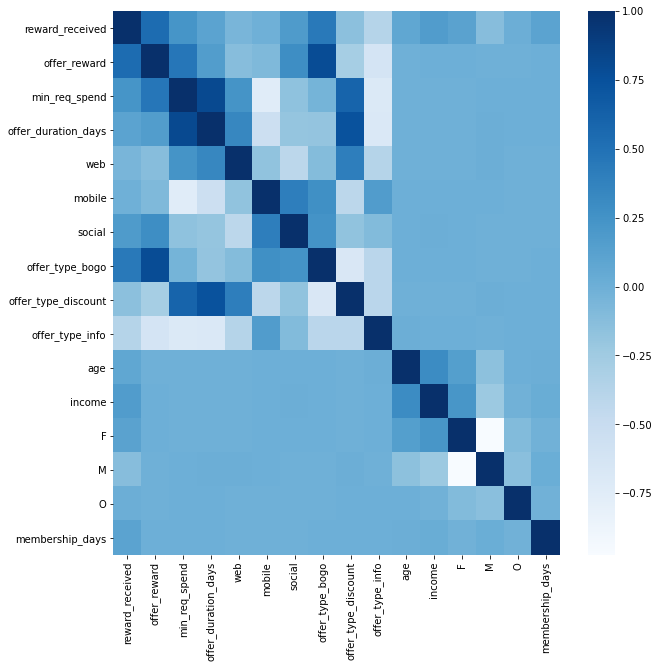

In [124]:
plt.figure(figsize=(10, 10))
sns.heatmap(correlation_matrix, cmap = 'Blues');

In [125]:
correlation_matrix

,reward_received,offer_reward,min_req_spend,offer_duration_days,web,mobile,social,offer_type_bogo,offer_type_discount,offer_type_info,age,income,F,M,O,membership_days
reward_received,1.000000,0.541450,0.236109,0.107979,-0.050363,-0.006079,0.182526,0.448699,-0.143684,-0.373230,0.077332,0.173090,0.119353,-0.121710,0.012349,0.111010
offer_reward,0.541450,1.000000,0.464809,0.164091,-0.120697,-0.079291,0.286995,0.791481,-0.286004,-0.618502,-0.001906,0.002980,0.003682,-0.002545,-0.004784,0.003595
min_req_spend,0.236109,0.464809,1.000000,0.810258,0.244007,-0.744192,-0.158661,-0.032824,0.600360,-0.694896,-0.007225,-0.002215,-0.002984,0.003028,-0.000244,0.004471
offer_duration_days,0.107979,0.164091,0.810258,1.000000,0.341505,-0.533608,-0.188655,-0.183809,0.741262,-0.682626,-0.007637,-0.004886,-0.007954,0.007544,0.001600,0.003137
web,-0.050363,-0.120697,0.244007,0.341505,1.000000,-0.169116,-0.412517,-0.104923,0.409947,-0.373518,-0.001751,-0.005866,-0.005532,0.006778,-0.005427,-0.003020
mobile,-0.006079,-0.079291,-0.744192,-0.533608,-0.169116,1.000000,0.409963,0.274884,-0.412533,0.168672,0.002566,0.005275,0.000661,0.000361,-0.004353,-0.005298
social,0.182526,0.286995,-0.158661,-0.188655,-0.412517,0.409963,1.000000,0.249826,-0.169462,-0.098271,0.000197,0.006665,0.004598,-0.003807,-0.003292,-0.002935
offer_type_bogo,0.448699,0.791481,-0.032824,-0.183809,-0.104923,0.274884,0.249826,1.000000,-0.666333,-0.408037,0.002747,0.002880,0.003923,-0.002885,-0.004357,0.000970
offer_type_discount,-0.143684,-0.286004,0.600360,0.741262,0.409947,-0.412533,-0.169462,-0.666333,1.000000,-0.408868,-0.008237,-0.003674,-0.007324,0.007048,0.001037,-0.000939
offer_type_info,-0.373230,-0.618502,-0.694896,-0.682626,-0.373518,0.168672,-0.098271,-0.408037,-0.408868,1.000000,0.006724,0.000973,0.004166,-0.005099,0.004062,-0.000038


In [126]:
correlated_cols = set()
for j in range(len(correlation_matrix.columns)):
    for i in range(j):
        if abs(correlation_matrix.iloc[i, j]) > 0.8:
            col_name = correlation_matrix.columns[j]
            correlated_cols.add(col_name)
correlated_cols

{'M', 'offer_duration_days'}

Negative correlation of columns M and F is very high at -0.97, which is not unexpected - so we can remove M.

In [127]:
X_train = X_train.drop(['M'], axis=1)
X_test = X_test.drop(['M'], axis=1)
X_train.shape, X_test.shape

((53256, 15), (13315, 15))

In [146]:
logisticRegr = LogisticRegression(max_iter = 200)
logisticRegr.fit(X_train, y_train)

LogisticRegression(max_iter=200)

In [147]:
y_hat = logisticRegr.predict(X_train)
y_hat

array([1, 0, 0, ..., 0, 0, 1])

In [150]:
print(f'accuracy {metrics.accuracy_score(y_train, y_hat)}')
print(f'confusion matrix\n {metrics.confusion_matrix(y_train, y_hat)}')
print(f'classificaiton report\n {metrics.classification_report(y_train, y_hat)}')

accuracy 0.7895072855640679
confusion matrix
 [[24620  6593]
 [ 4617 17426]]
classificaiton report
               precision    recall  f1-score   support

           0       0.84      0.79      0.81     31213
           1       0.73      0.79      0.76     22043

    accuracy                           0.79     53256
   macro avg       0.78      0.79      0.79     53256
weighted avg       0.79      0.79      0.79     53256



Let's see if the results improve after we scale the data.

In [158]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [159]:
logisticRegr = LogisticRegression(max_iter = 200)
logisticRegr.fit(X_train_scaled, y_train)

LogisticRegression(max_iter=200)

In [160]:
y_hat = logisticRegr.predict(X_train_scaled)
y_hat

array([1, 0, 0, ..., 0, 0, 1])

In [161]:
print(f'accuracy {metrics.accuracy_score(y_train, y_hat)}')
print(f'confusion matrix\n {metrics.confusion_matrix(y_train, y_hat)}')
print(f'classificaiton report\n {metrics.classification_report(y_train, y_hat)}')

accuracy 0.7994404386360222
confusion matrix
 [[26334  4879]
 [ 5802 16241]]
classificaiton report
               precision    recall  f1-score   support

           0       0.82      0.84      0.83     31213
           1       0.77      0.74      0.75     22043

    accuracy                           0.80     53256
   macro avg       0.79      0.79      0.79     53256
weighted avg       0.80      0.80      0.80     53256



Results do improve a little bit. <br>
As we can see in the support column, there is a slight imbalance in the dataset, however nothing out of the ordinary.

Napomena kad dođem do toga:


Models such as logistic regression, linear regression, or other models that involve a matrix are very sensitive to different scales of input variables. If we use such data for model fitting, the result might end up creating a bias. Therefore feature scaling techniques are used before model fitting.

(iz C:\Users\josip\OneDrive\Documents\DataScienceDONE\2_virtual_classroom_materials\day_3_feature_engineering\3. Numerical_features)